In [1]:
import pandas as pd
import numpy as np
from nltk import word_tokenize
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
lyricsdf = pd.read_csv("song_lyrics.csv")

### <span style="color:teal"> To start, the dataframe has ~5 million songs, which needs to be filtered to only include relevant and accurate entries that will be useful in providing recommendations and classifying by artist and genre.

In [3]:
lyricsdf.shape

(5134856, 11)

In [4]:
lyrics_df = lyricsdf.copy()
lyrics_df.head(5)

,title,tag,artist,year,views,features,lyrics,id,language_cld3,language_ft,language
0,Killa Cam,rap,Cam'ron,2004,173166,"{""Cam\\'ron"",""Opera Steve""}","[Chorus: Opera Steve & Cam'ron]\nKilla Cam, Ki...",1,en,en,en
1,Can I Live,rap,JAY-Z,1996,468624,{},"[Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...",3,en,en,en
2,Forgive Me Father,rap,Fabolous,2003,4743,{},Maybe cause I'm eatin\nAnd these bastards fien...,4,en,en,en
3,Down and Out,rap,Cam'ron,2004,144404,"{""Cam\\'ron"",""Kanye West"",""Syleena Johnson""}",[Produced by Kanye West and Brian Miller]\n\n[...,5,en,en,en
4,Fly In,rap,Lil Wayne,2005,78271,{},"[Intro]\nSo they ask me\n""Young boy\nWhat you ...",6,en,en,en


<Axes: title={'center': 'Songs per Genre Before Preprocessing'}, xlabel='genre', ylabel='# of songs'>

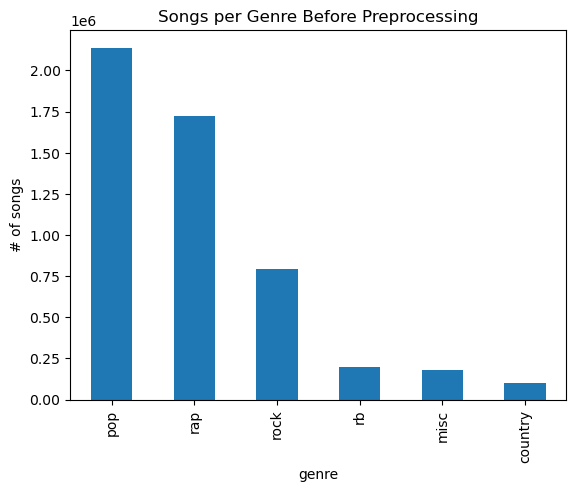

In [5]:
lyrics_df["tag"].value_counts().plot(kind="bar", ylabel="# of songs", xlabel="genre", title="Songs per Genre Before Preprocessing")

# <span style="color:teal"> <u>**Data Pre-Processing**

### <span style="color:teal"> Removing misc and country genres from dataset due to irrelevance for misc and limited examples for country:

In [6]:
#drops misc genre since mostly non-songs
miscidx = lyrics_df.loc[lyrics_df["tag"] == "misc"].index
lyrics_df = lyrics_df.drop(index=miscidx)
#drops country genre since datapoints are too limited to accurately predict.
countryidx = lyrics_df.loc[lyrics_df["tag"] == "country"].index
lyrics_df = lyrics_df.drop(index=countryidx)

### <span style="color:teal"> Removing songs with features to ensure no misattribution due to multiple artists on a song:

In [7]:
#removes the rest of songs with features to help with authorship attribution
songs_w_features_idx = lyrics_df.loc[lyrics_df["features"] != "{}"].index
print("# of songs before removing songs w features: ", lyrics_df.shape[0])
lyrics_df = lyrics_df.drop(index=songs_w_features_idx)
print("# of songs after removing: ", lyrics_df.shape[0])

# of songs before removing songs w features:  4853085
# of songs after removing:  3729179


### <span style="color:teal">As shown below, some artists' songs under their names are either live versions, or songs not belonging to them. There are also translations which will be removed since it is difficult to extract artist from titles and determine which translations are accurate.

In [8]:
print("songs by artist:", lyrics_df["artist"].value_counts().head(5), "\n")
print("\nsongs by language:", lyrics_df["language"].value_counts().head(5))

songs by artist: artist
Genius Romanizations           16161
Genius English Translations    13625
The Grateful Dead               2109
Genius Traduzioni Italiane      1640
Tendon Levey                    1320
Name: count, dtype: int64 


songs by language: language
en    2600216
es     187772
fr     132149
de     119157
pt      99443
Name: count, dtype: int64


### <span style="color:teal"> In order to avoid misattributions or unreliable transcriptions, only songs with over 10,000 views are used. In addition, non-english language songs are dropped to focus only on english language data.

In [9]:
#to avoid live version duplicates and misattributed songs, I will 
#only take songs with over 5000 views (may adjust later).
over_views_idx = lyrics_df.loc[lyrics_df["views"] < 10000].index
print("# of songs before removing <10000 views:", lyrics_df.shape[0])
lyrics_df = lyrics_df.drop(index=over_views_idx)
print("# of songs after removing:", lyrics_df.shape[0])
#also drops songs starting with genius which are either songs in
#lanugages other than english or translations
non_en_idx = lyrics_df.loc[lyrics_df["language"] != "en"].index
print("# of songs before removing translations:", lyrics_df.shape[0])
lyrics_df = lyrics_df.drop(index=non_en_idx)
translated_idx = lyrics_df.loc[lyrics_df["artist"].str.startswith("Genius")].index
lyrics_df = lyrics_df.drop(index=translated_idx)
print("# of songs after removing:", lyrics_df.shape[0])

# of songs before removing <10000 views: 3729179
# of songs after removing: 120663
# of songs before removing translations: 120663
# of songs after removing: 84152


### <span style="color:teal"> To further improve reliability of data, only artists with 20 or more songs over 10000 views are included. This also will help classification by ensuring each artist has at least 20 songs to train from. Accuracy could be improved greatly for artist classification by further increasing these parameters, but I wanted to still have a sizeable number of artists both for recommendations and classification.

In [10]:
#gets and drops the indexes of songs whose artists have less than 20 songs over 10000 views in the whole dataset. 
#This also includes many songs with multiple artists since it would be difficult to find author autribution from those.
few_songs_idx = lyrics_df[lyrics_df.groupby("artist")["artist"].transform('size')<20]["artist"].index
print("# of songs before removing artists with <10 songs: ", lyrics_df.shape[0])
lyrics_df = lyrics_df.drop(index=few_songs_idx)
print("# of songs after removing: ", lyrics_df.shape[0])

# of songs before removing artists with <10 songs:  84152
# of songs after removing:  43712


In [11]:
# drops features and language columns
lyrics_df = lyrics_df.drop(columns=["features", "language_cld3", "language_ft", "language"])
#drops missing titles (only 5)
lyrics_df = lyrics_df.dropna(axis="index")
#replaces zerospace characters in titles
lyrics_df["title"] = lyrics_df["title"].str.replace("\u200b", "")


### <span style="color:teal"> As shown below, many artists have large numbers of songs, which imbalances the data towards these artists. However, these artists tend to be the most popular and attempts at downsampling utimately limits the data and makes it more difficult to give recommendations and identify these artists.

In [12]:
lyrics_df["artist"].value_counts()

artist
Juice WRLD                    533
YoungBoy Never Broke Again    308
Lil Wayne                     308
Chief Keef                    280
BONES                         277
                             ... 
Ramones                        20
Dean Lewis                     20
Central Cee                    20
Blueface                       20
The Streets                    20
Name: count, Length: 904, dtype: int64

### <span style="color:teal"> Below is an earlier attempt at downsampling artists, however this ultimately harmed results for both artist attribution and genre attribution while also limiting the number of songs available for recommendation, so I did not end up using it for the final results:

In [13]:
# print("# of songs before downsampling songs to balance artist counts: ", lyrics_df.shape[0])
# artist_counts = lyrics_df["artist"].value_counts()
# over50 = artist_counts[artist_counts > 50].index
# for artist in over50:
#     #gets index of all songs for artist below their top 50 most viewed
#     nottop50 = lyrics_df.loc[lyrics_df["artist"] == artist].sort_values(by="views", ascending=False).iloc[50:].index
#     lyrics_df = lyrics_df.drop(index = nottop50)
# print("# of songs after: ", lyrics_df.shape[0])


### <span style="color:teal"> After finishing most of the preprocessing, the dataset is left with ~43k songs and ~900 unique artists:

In [14]:
print("TOTAL SONGS:", lyrics_df.shape[0])
print("TOTAL ARTISTS:", lyrics_df["artist"].unique().shape[0])

TOTAL SONGS: 43709
TOTAL ARTISTS: 904


### <span style="color:teal">Based on the distribution of genres after preprocessing below, I will later attempt to balance out the classes in order to see if that will avoid any biases in classification that may be caused by this imbalance of songs per genre.

<Axes: title={'center': 'Songs per Genre After Preprocessing'}, xlabel='genre', ylabel='# of songs'>

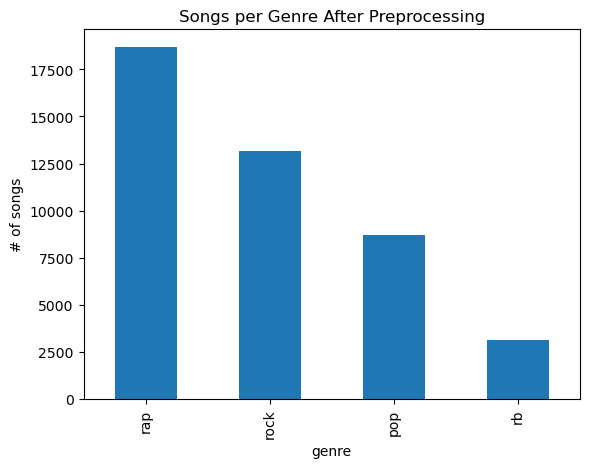

In [15]:
lyrics_df["tag"].value_counts().plot(kind="bar", ylabel="# of songs", xlabel="genre", title="Songs per Genre After Preprocessing")

### <span style="color:teal"> Visualization of most popular genres after reduction, not important for the project objectives but interesting to see nonetheless:

rap avg view count: 115935
rock avg view count: 64394
pop avg view count: 133052
rb avg view count: 144235


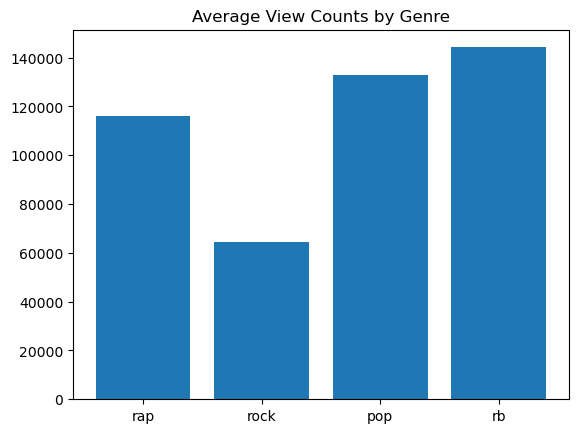

In [16]:
view_count_list = []
genre_list = []
for genre in lyrics_df["tag"].unique():
    view_count = lyrics_df.loc[lyrics_df["tag"] == genre]["views"].sum()
    view_count_avg = view_count//lyrics_df.loc[lyrics_df["tag"] == genre].shape[0]
    print(genre, "avg view count:", view_count_avg)
    view_count_list.append(view_count_avg)
    genre_list.append(genre)
plt.bar(range(len(genre_list)), view_count_list)
plt.xticks(range(len(genre_list)), genre_list)
plt.title("Average View Counts by Genre")
plt.show()


# <span style="color:teal"> <u>**Tokenizing Lyrics**   

In [17]:
#function to tokenize words in a song
def sent_transform(sent_string):
    return [word.lower().strip() for word in word_tokenize(sent_string)]

# function to remove any non-lyric data from the lyrics, for example "[intro]"
def remove_notes(song_lyrics):
    return re.sub(r"\[(?:[^\]]*)\]", "", song_lyrics)

In [18]:
print("example of lyrics before tokenizing")
lyrics_df["lyrics"].head(5)

example of lyrics before tokenizing


1     [Produced by Irv Gotti]\n\n[Intro]\nYeah, hah,...
4     [Intro]\nSo they ask me\n"Young boy\nWhat you ...
10    [Intro]\nYeah\nMoney on my mind, money on my m...
12    [Produced by DJ Premier]\n\n[Hook Samples: Sno...
13    [Produced by Just Blaze]\n\n[Intro: Gloria Car...
Name: lyrics, dtype: object

In [19]:
lyrics_df["lyrics"] = lyrics_df["lyrics"].apply(remove_notes).apply(sent_transform)
lyrics_df = lyrics_df.reset_index(drop=True)

In [20]:
print("example of lyrics after tokenizing")
lyrics_df["lyrics"].head(5)

example of lyrics after tokenizing


0    [yeah, ,, hah, ,, yeah, ,, roc-a-fella, we, in...
1    [so, they, ask, me, '', young, boy, what, you,...
2    [yeah, money, on, my, mind, ,, money, on, my, ...
3    ['', dear, god, –, i, wonder, ,, can, you, sav...
4    [shawn, carter, was, born, december, 4th, ,, w...
Name: lyrics, dtype: object

### <span style="color:teal"> Final bit of preprocessing after tokenizing to remove songs with >4000 tokens, which mostly include non-song data or are song compilations:

In [21]:
over4000idx = lyrics_df.loc[lyrics_df["lyrics"].apply(len) > 4000].index
lyrics_df = lyrics_df.drop(index=over4000idx)
lyrics_df = lyrics_df.reset_index(drop=True)

# <span style="color:teal"> <u>**Train Test Split & Baseline Model:**

In [22]:
print("Final # of songs:", lyrics_df.shape[0])
print("Final # of artists:", len(lyrics_df["artist"].unique()))
lyrics_df.head(5)

Final # of songs: 43697
Final # of artists: 904


,title,tag,artist,year,views,lyrics,id
0,Can I Live,rap,JAY-Z,1996,468624,"[yeah, ,, hah, ,, yeah, ,, roc-a-fella, we, in...",3
1,Fly In,rap,Lil Wayne,2005,78271,"[so, they, ask, me, '', young, boy, what, you,...",6
2,Money On My Mind,rap,Lil Wayne,2005,128927,"[yeah, money, on, my, mind, ,, money, on, my, ...",12
3,DEvils,rap,JAY-Z,1996,504959,"['', dear, god, –, i, wonder, ,, can, you, sav...",14
4,December 4th,rap,JAY-Z,2003,283714,"[shawn, carter, was, born, december, 4th, ,, w...",15


### <span style="color:teal"> Train/test split with an 80/20 split, with additional seperation of y into genre and artist for predicted classes:

In [23]:
X = lyrics_df["lyrics"]
y = lyrics_df[["tag", "artist"]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

y_train_artist = y_train["artist"]
y_train_tag = y_train["tag"]
y_test_artist = y_test["artist"]
y_test_tag = y_test["tag"]

### <span style="color:teal"> Bag of words vectorization of lyric tokens, fit and transformed on lyric train data and transformed on lyric test data:

In [24]:
def dummy(doc):
    return doc
vectorizer = CountVectorizer(tokenizer=dummy, preprocessor=dummy)
X_train_BoW = vectorizer.fit_transform(X_train)
X_test_BoW = vectorizer.transform(X_test)

/Users/michael.781/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### <span style="color:teal"> Functions for ease of use when building models:

In [25]:
def fit_predict_artists(model, model_name, input_type):
    #if Word2Vec vectorization, uses word2vec embeddings on train and test X
    if input_type == "Word2Vec":
        model.fit(X_train_embeddings, y_train_artist)
        predictions = model.predict(X_test_embeddings)
    #else if bag of words, uses bag of words vectorization on train and test x
    else:
        model.fit(X_train_BoW, y_train_artist)
        predictions = model.predict(X_test_BoW)
    
    #prints total correct out of total predicted for artists, a classification report with precision and recall is difficult due to the ~900 artists
    true_artist = y_test_artist.to_numpy()
    totalcorrect = (true_artist == predictions).sum()
    totaltest = len(true_artist)
    print(f"{totalcorrect} correct artists/{totaltest} total artists, using {model_name} with {input_type} = accuracy of {totalcorrect/totaltest}")

In [26]:
from sklearn.metrics import classification_report
def fit_predict_genre(model, model_name, input_type, balanced=False):
    #if Word2Vec vectorization, uses word2vec embeddings on train and test X
    if input_type == "Word2Vec":
        #if balanced is specified in parameter, uses upsampled genre data calculated with RandomOverSampler from imblearn.
        if balanced:
            model.fit(X_train_embeddings_genre, y_train_genre)
            predictions = model.predict(X_test_embeddings)
        #otherwise uses regular X train without upsampling
        else:
            model.fit(X_train_embeddings, y_train_tag)
            predictions = model.predict(X_test_embeddings)
    #else if bag of words, uses bag of words vectorization on train and test x
    else:
        model.fit(X_train_BoW, y_train_tag)
        predictions = model.predict(X_test_BoW)
    #prints classification report with accuracy as well as precision, recall, and f1 for each genre.
    print(f"Genre results for {model_name} with {input_type}:")
    print(classification_report(y_test_tag, predictions))

# <span style="color:teal"> <u>Baseline Naive Bayes Model using Bag of Words vectorization:

In [27]:
from sklearn.naive_bayes import MultinomialNB
NB_artist_model = MultinomialNB()
fit_predict_artists(NB_artist_model, "Naive Bayes", "Bag of Words")

362 correct artists/8740 total artists, using Naive Bayes with Bag of Words = accuracy of 0.0414187643020595


In [28]:
NB_genre_model = MultinomialNB()
fit_predict_genre(NB_genre_model, "Naive Bayes", "Bag of Words")

Genre results for Naive Bayes with Bag of Words:
              precision    recall  f1-score   support

         pop       0.46      0.54      0.50      1696
         rap       0.93      0.85      0.88      3736
          rb       0.41      0.29      0.34       635
        rock       0.68      0.73      0.70      2673

    accuracy                           0.71      8740
   macro avg       0.62      0.60      0.61      8740
weighted avg       0.72      0.71      0.71      8740



# <span style="color:teal"> <u>Word2Vec embeddings trained on lyric data:

### <span style="color:teal"> For my non-baseline models, I decided to use Word2Vec embeddings due to their abililty to capture word/token semantics which I expect to be more useful than a basic bag of words approach, since they should more accurately be able to represent the meaning/topic of a specific song. I would expect this representation will allow for better groupings of data by artist and genre.

In [29]:
from gensim.models import Word2Vec
#generates word embeddings trained on all songs in x_train
songlist = X_train.to_list()
lyrics_embeddings = Word2Vec(sentences=songlist, min_count=1)
print(lyrics_embeddings)

Word2Vec<vocab=102687, vector_size=100, alpha=0.025>


### <span style="color:teal"> Shown below is the effects of training the embeddings on the lyric data, where a word like **ice** (which is often used as slang for diamonds) is most similar to watches & diamond types, rather than with the pretrained embeddings where it would be similar to freeze, water, glacier etc.

In [30]:
print(lyrics_embeddings.wv.most_similar(["ice"]))

[('wrist', 0.6800469756126404), ('froze', 0.6456757187843323), ('cream', 0.6302452087402344), ('baguettes', 0.6294153332710266), ('patek', 0.6287558674812317), ('vvs', 0.6152169108390808), ('rubik', 0.6136263012886047), ('necklace', 0.6107965111732483), ('icy', 0.6084887981414795), ('glacier', 0.5953954458236694)]


### <span style="color:teal"> In order to use these embeddings efficiently for training the models, I took the average embeddings for each word in each song, which results in a 100 dimension representation of the embeddings.

In [31]:
def get_avg_embeddings(lyrics_list):
    
    lyrics_array = lyrics_list.copy().to_list()
    #iterates over array of tokenized songs, taking the average of each of their token embeddings, then using that average as the song's embedding.
    for idx, lyrics in enumerate(lyrics_array):
        lyrics_in_vocab = [word for word in lyrics if word in lyrics_embeddings.wv.key_to_index]
        lyrics_avg = np.mean(lyrics_embeddings.wv[lyrics_in_vocab], axis=0)
        lyrics_array[idx] = lyrics_avg
    return lyrics_array

### <span style="color:teal"> These average embeddings are calculated for to both the train and test data, and then the total lyrics in both which will be used seperately to generate song recommendations.

In [32]:
#gets average embeddings for X_train and X_test, as well as total embeddings to use for recommendations
X_train_embeddings = get_avg_embeddings(X_train)
X_test_embeddings = get_avg_embeddings(X_test)
X_total_embeddings = get_avg_embeddings(X)

### <span style="color:teal"> As shown earlier and below, there is an imbalance in genres which I want to fix in order to test if performance can be improved.

In [33]:
print(y_train_tag.value_counts())

tag
rap     14942
rock    10507
pop      7030
rb       2478
Name: count, dtype: int64


### <span style="color:teal"> To fix this imbalance, I will use the RandomOverSampler from imblearn which I specify to randomly sample from the training embeddings of minority classes, in order to create data points for these minority classes and balance them with the majority.

In [34]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(sampling_strategy="not majority")
X_train_embeddings_genre, y_train_genre = ros.fit_resample(X_train_embeddings, y_train_tag)


### <span style="color:teal"> As shown below, this results in an even split between all classes and will be used when model training to see if better performance can be achieved.

In [35]:
y_train_genre.value_counts()

tag
rap     14942
rock    14942
pop     14942
rb      14942
Name: count, dtype: int64

# <span style="color:teal"> <u>Song Recommendations:

### <span style="color:teal"> I created a function which calculates euclidian distance between song embeddings in order to determine the *num_reccomendations* closest songs to the specified song and artist.

In [36]:
def return_recommendations(num_reccomendations, song_name, song_artist):
    #list of distances from current song to each song in lyrics_df
    dist_array = []
    #gets the index of the specified song
    song_idx = lyrics_df.loc[(lyrics_df["title"] == song_name) & (lyrics_df["artist"] == song_artist)].index[0]
    #gets the song embeddings for the specified song
    song_avg_embeddings = X_total_embeddings[song_idx]
    #iterates over each song in X_total_embeddings (which lines up with songs in lyrics_df)
    for idx, cur_song_avg in enumerate(X_total_embeddings):
        #calculates distance between specified song and current song in iteration using euclidian distance
        cur_distance = np.linalg.norm(song_avg_embeddings - cur_song_avg)
        #appends a tuple of the distance and song idx to dist_array
        dist_array.append((cur_distance, idx))
    #after all distances calculated, sorts by descending distances
    song_distances = sorted(dist_array)
    #returns the top num_recommendations results (excluding the closest since it will always be the specified song) with song name and artist
    for idx in range(1, num_reccomendations + 1):
        cur_idx = song_distances[idx][1]
        print(f"{lyrics_df.iloc[cur_idx]['title']}, by {lyrics_df.iloc[cur_idx]['artist']}")
    

### <span style="color:teal"> Some examples of recommendations for each genre: r&b with The Weeknd, rap with Travis Scott, pop with Taylor Swift, and rock with Imagine Dragons. The recommendations tend to stick within the genre and are similar topics even if the vibe of the song is different due to the instrumental or the style.

In [37]:
return_recommendations(5, "The Hills", "The Weeknd")

IDK What Love Is, by Wicca Phase Springs Eternal
Wedding, by Mac Miller
The King, by Conan Gray
On to the Next One, by Tink
Fucking Fans, by Drake


In [38]:
return_recommendations(5, "BUTTERFLY EFFECT", "Travis Scott")

Keep Being Me, by Lil Uzi Vert
The Hooch, by Travis Scott
HOUSTONFORNICATION Demo, by Travis Scott
CRANK, by City Morgue
Caligula, by City Morgue


In [39]:
return_recommendations(5, "cardigan", "Taylor Swift")

cardigan voice memo, by Taylor Swift
You Know Im No Good, by Amy Winehouse
Poison Oak, by Bright Eyes
Annie, by Manchester Orchestra
You Grew On Me, by Tim Minchin


In [40]:
return_recommendations(5, "Believer", "Imagine Dragons")

Believer Kaskade Remix, by Imagine Dragons
Believer, by AURORA
Arcadia, by Lana Del Rey
Skywalker, by Denzel Curry
untitled 01 | 08.19.2014., by Kendrick Lamar


In [41]:
# A helper to find exact song names by looking up most popular songs by an artist
# lyrics_df.loc[lyrics_df["artist"] == "Imagine Dragons"].sort_values(by="views", ascending=False)

# <span style="color:teal"> <u>Classification Models:

### <span style="color:teal"> To start, I tested a K-nearest neighbors classifier since I imagined similar songs would be close together, and hoped songs by artist as well as genre would be neighbors.

In [42]:
from sklearn.neighbors import KNeighborsClassifier
KN_model = KNeighborsClassifier(n_neighbors=2)
fit_predict_artists(KN_model, "K-Nearest Neighbors", "Word2Vec")


615 correct artists/8740 total artists, using K-Nearest Neighbors with Word2Vec = accuracy of 0.07036613272311212


In [43]:
KN_model = KNeighborsClassifier(n_neighbors=10)
fit_predict_genre(KN_model, "K-Nearest Neighbors", "Word2Vec")

Genre results for K-Nearest Neighbors with Word2Vec:
              precision    recall  f1-score   support

         pop       0.42      0.31      0.36      1696
         rap       0.69      0.96      0.80      3736
          rb       0.37      0.14      0.20       635
        rock       0.68      0.53      0.60      2673

    accuracy                           0.64      8740
   macro avg       0.54      0.49      0.49      8740
weighted avg       0.61      0.64      0.61      8740



### <span style="color:teal"> In order to test if misclassification was due in part to imbalances, I ran the same model with the balanced training data from before, however results were only slightly better for r&b, and decreased for all other genres.

In [44]:
KN_model=KNeighborsClassifier(n_neighbors=10)
fit_predict_genre(KN_model, "K-Nearest Neighbors", "Word2Vec", balanced=True)


Genre results for K-Nearest Neighbors with Word2Vec:
              precision    recall  f1-score   support

         pop       0.39      0.33      0.36      1696
         rap       0.80      0.88      0.83      3736
          rb       0.20      0.47      0.28       635
        rock       0.68      0.44      0.54      2673

    accuracy                           0.61      8740
   macro avg       0.52      0.53      0.50      8740
weighted avg       0.64      0.61      0.61      8740



### <span style="color:teal"> After testing a k-nearest neighbors model, I decided to try a multilayer perceptron due to its ability to handle non-linear data, since I initially believed artists would not be due to the embeddings picking up on topics rather than specific artist style.

In [45]:
from sklearn.neural_network import MLPClassifier
NN_model = MLPClassifier(hidden_layer_sizes=100, activation="relu", early_stopping=True, max_iter=10)
fit_predict_artists(NN_model, "Multilayer Perceptron", "Word2Vec")

853 correct artists/8740 total artists, using Multilayer Perceptron with Word2Vec = accuracy of 0.09759725400457665


/Users/michael.781/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


In [46]:
NN_model = MLPClassifier(hidden_layer_sizes=100, activation="relu", early_stopping=True, max_iter=10)
fit_predict_genre(NN_model, "Multilayer Perceptron", "Word2Vec")

/Users/michael.781/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Genre results for Multilayer Perceptron with Word2Vec:
              precision    recall  f1-score   support

         pop       0.47      0.42      0.45      1696
         rap       0.88      0.91      0.89      3736
          rb       0.47      0.12      0.19       635
        rock       0.66      0.79      0.72      2673

    accuracy                           0.72      8740
   macro avg       0.62      0.56      0.56      8740
weighted avg       0.70      0.72      0.70      8740



### <span style="color:teal"> The multilayer perceptron performed better than both the baseline and KNN model for artist classification, and did an overall better job classifying genres outside of classifying r&b where it dropped to only a .07 f1. However, it does very well for rap and rock, and only slightly worse for pop.

In [47]:
NN_model = MLPClassifier(hidden_layer_sizes=100, activation="relu", early_stopping=True, max_iter=10)
fit_predict_genre(NN_model, "Multilayer Perceptron", "Word2Vec", balanced=True)

/Users/michael.781/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Genre results for Multilayer Perceptron with Word2Vec:
              precision    recall  f1-score   support

         pop       0.48      0.40      0.43      1696
         rap       0.93      0.85      0.89      3736
          rb       0.27      0.49      0.35       635
        rock       0.69      0.70      0.69      2673

    accuracy                           0.69      8740
   macro avg       0.59      0.61      0.59      8740
weighted avg       0.72      0.69      0.70      8740



### <span style="color:teal"> Trying with the upsampled data, the performance is better for r&b, but drops off slightly for the others. If the goal is to improve r&b accuracy it does a better job, but aside from that it decreases performace for the others.

_________________________________________________________________________________________________________________________________________________________________________________

### <span style="color:teal"> After the multilayer perceptron, I tried a random forest classifier using 100 decision trees, although only on the genre classification since for artist classification there are too many classes to calculate accurately and efficiently. I wanted to try decision trees due to their ability to seperate the data into quadrants based on class which I thought would be helpful in identify data clusters of related artists & genres.

In [48]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 100)
fit_predict_genre(model, "decision tree", "Word2Vec")

Genre results for decision tree with Word2Vec:
              precision    recall  f1-score   support

         pop       0.43      0.39      0.41      1696
         rap       0.88      0.89      0.89      3736
          rb       0.49      0.09      0.14       635
        rock       0.63      0.78      0.70      2673

    accuracy                           0.70      8740
   macro avg       0.61      0.54      0.54      8740
weighted avg       0.69      0.70      0.68      8740



### <span style="color:teal"> Finally, in order to test for some linear relationship in the data I tried a Logistic Regression model, and although it took around 2 minutes, it correctly predicted around 16% of artists, which is much better than any other model I tried.

In [49]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression(max_iter=200)
fit_predict_artists(logmodel, "log reg", "Word2Vec")

1395 correct artists/8740 total artists, using log reg with Word2Vec = accuracy of 0.15961098398169338


/Users/michael.781/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [50]:
logmodel = LogisticRegression(max_iter=200)
fit_predict_genre(logmodel, "log reg", "Word2Vec")

/Users/michael.781/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Genre results for log reg with Word2Vec:
              precision    recall  f1-score   support

         pop       0.47      0.41      0.44      1696
         rap       0.87      0.90      0.88      3736
          rb       0.42      0.14      0.21       635
        rock       0.65      0.78      0.71      2673

    accuracy                           0.71      8740
   macro avg       0.60      0.56      0.56      8740
weighted avg       0.69      0.71      0.70      8740



### <span style="color:teal"> To conclude, the model with the best performance on both classification tasks ended up being the logistic regression model, which was surprising since I initially expected K-Nearest neigbors to perform the best due to an expectation of lyrics from artists & genres tending to be closer together. In comparison to the baseline, it performed 5x better in terms of accuracy on artist classification at ~16%, but performed about the same for genre classification. In the future, If I wanted to expand on this project, one way I may be able to improve my results would be to use bert embeddings to get contextualized embeddings which may help when predicting genre and assessing a song's topic. I could also limit my artist classification to either predict if a song belongs to a specific artist or not.